In [13]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [14]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


## ID별 CGM 결측치 확인

In [15]:
for id in range(1, len(dg_df)+1):
    #if id == 15: # Skip ID 15
    #    continue
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    print(f'[ID: {id}] Now processing ...')

    ## Dexcom Glucose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    # 시간 간격 계산
    dexcom_df['time_diff'] = dexcom_df.index.to_series().diff().dt.total_seconds() / 60.0

    # 결측치에 대해 NaN을 삽입
    # 4분에서 6분 사이가 아닌 시간 간격을 찾기
    new_rows = []
    for i in range(1, len(dexcom_df)):
        if dexcom_df['time_diff'].iloc[i] > 6 or dexcom_df['time_diff'].iloc[i] < 4:
            num_missing = int(dexcom_df['time_diff'].iloc[i] // 5)  # 5분 간격으로 결측값 삽입
            for j in range(1, num_missing + 1):
                missing_time = dexcom_df.index[i-1] + pd.Timedelta(minutes=5*j)
                new_rows.append(pd.DataFrame({'glucose': [np.nan]}, index=[missing_time]))

    # 새로 생성된 행을 기존 데이터프레임에 추가
    if new_rows:
        new_rows_df = pd.concat(new_rows)
        dexcom_df = pd.concat([dexcom_df, new_rows_df]).sort_index()

    # 시간순으로 정렬
    dexcom_df.sort_index(inplace=True)

    # 보간 전 결측값 구간 출력
    print(f"[ID {id}] 보간 전 결측값이 있는 구간:")
    print(dexcom_df[dexcom_df['glucose'].isnull()])
    dexcom_df[dexcom_df['glucose'].isnull()].to_csv(rf'./missing_cgm_csv/id_{id}_missing.csv', sep='\t', encoding='utf-8', header='true')

    # 다양한 보간법 사용 (선형 보간을 예시로 사용)
    dexcom_df['glucose'] = dexcom_df['glucose'].interpolate(method='linear')

    # 보간 후 결측값 구간 출력
    print("\n[ID {id}] 보간 후 결측값이 있는 구간:")
    print(dexcom_df[dexcom_df['glucose'].isnull()])


[ID: 1] Now processing ...
[ID 1] 보간 전 결측값이 있는 구간:
                     glucose  time_diff
2020-02-15 09:08:30      NaN        NaN
2020-02-15 09:13:30      NaN        NaN
2020-02-19 23:43:26      NaN        NaN
2020-02-19 23:48:26      NaN        NaN
2020-02-19 23:53:26      NaN        NaN
2020-02-19 23:58:26      NaN        NaN
2020-02-20 00:03:26      NaN        NaN
2020-02-20 00:08:26      NaN        NaN
2020-02-20 00:13:26      NaN        NaN
2020-02-20 00:18:26      NaN        NaN
2020-02-20 00:23:26      NaN        NaN
2020-02-20 00:28:26      NaN        NaN
2020-02-20 00:33:26      NaN        NaN
2020-02-20 00:38:26      NaN        NaN
2020-02-20 00:43:26      NaN        NaN
2020-02-20 00:48:26      NaN        NaN
2020-02-20 00:53:26      NaN        NaN
2020-02-20 00:58:26      NaN        NaN
2020-02-20 01:03:26      NaN        NaN
2020-02-20 01:08:26      NaN        NaN
2020-02-20 01:13:26      NaN        NaN
2020-02-20 01:18:26      NaN        NaN
2020-02-20 01:23:26      NaN 

## 특정 ID, 001에 대해 데이터 보간 후 CGM 시각화해보기

In [16]:
id = 1

dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

print(f'[ID: {id}] Now processing ...')

## Dexcom Glucose
dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
dexcom_df = dexcom_df[['datetime', 'glucose']]
dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
dexcom_df.set_index('datetime', inplace=True)

# 시간 간격 계산
dexcom_df['time_diff'] = dexcom_df.index.to_series().diff().dt.total_seconds() / 60.0

# 결측치에 대해 NaN을 삽입
# 4분에서 6분 사이가 아닌 시간 간격을 찾기
new_rows = []
for i in range(1, len(dexcom_df)):
    if dexcom_df['time_diff'].iloc[i] > 6 or dexcom_df['time_diff'].iloc[i] < 4:
        num_missing = int(dexcom_df['time_diff'].iloc[i] // 5)  # 5분 간격으로 결측값 삽입
        for j in range(1, num_missing + 1):
            missing_time = dexcom_df.index[i-1] + pd.Timedelta(minutes=5*j)
            new_rows.append(pd.DataFrame({'glucose': [np.nan]}, index=[missing_time]))

# 새로 생성된 행을 기존 데이터프레임에 추가
if new_rows:
    new_rows_df = pd.concat(new_rows)
    dexcom_df = pd.concat([dexcom_df, new_rows_df]).sort_index()

# 시간순으로 정렬
dexcom_df.sort_index(inplace=True)

# 보간 전 결측값 구간 출력
print(f"[ID {id}] 보간 전 결측값이 있는 구간:")
print(dexcom_df[dexcom_df['glucose'].isnull()])

# 다양한 보간법 사용 (선형 보간을 예시로 사용)
dexcom_df['glucose'] = dexcom_df['glucose'].interpolate(method='linear')

# 보간 후 결측값 구간 출력
print("\n[ID {id}] 보간 후 결측값이 있는 구간:")
print(dexcom_df[dexcom_df['glucose'].isnull()])

[ID: 1] Now processing ...
[ID 1] 보간 전 결측값이 있는 구간:
                     glucose  time_diff
2020-02-15 09:08:30      NaN        NaN
2020-02-15 09:13:30      NaN        NaN
2020-02-19 23:43:26      NaN        NaN
2020-02-19 23:48:26      NaN        NaN
2020-02-19 23:53:26      NaN        NaN
2020-02-19 23:58:26      NaN        NaN
2020-02-20 00:03:26      NaN        NaN
2020-02-20 00:08:26      NaN        NaN
2020-02-20 00:13:26      NaN        NaN
2020-02-20 00:18:26      NaN        NaN
2020-02-20 00:23:26      NaN        NaN
2020-02-20 00:28:26      NaN        NaN
2020-02-20 00:33:26      NaN        NaN
2020-02-20 00:38:26      NaN        NaN
2020-02-20 00:43:26      NaN        NaN
2020-02-20 00:48:26      NaN        NaN
2020-02-20 00:53:26      NaN        NaN
2020-02-20 00:58:26      NaN        NaN
2020-02-20 01:03:26      NaN        NaN
2020-02-20 01:08:26      NaN        NaN
2020-02-20 01:13:26      NaN        NaN
2020-02-20 01:18:26      NaN        NaN
2020-02-20 01:23:26      NaN 

In [17]:
fl_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/001/Food_Log_001.csv')

fl_df['date']=pd.to_datetime(fl_df['date'])
fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])

glucose      119.0
time_diff      5.0
Name: 2020-02-19 22:43:26, dtype: float64


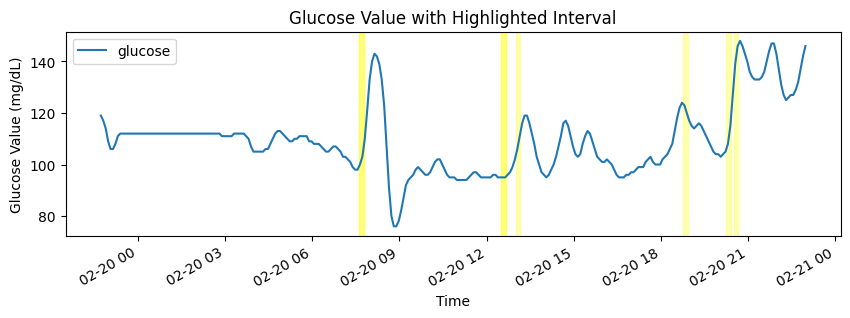

In [18]:
# 날짜 필터링
filtered_df = dexcom_df[(dexcom_df.index >= '2020-02-19 22:43:26') & (dexcom_df.index <= '2020-02-20 22:59:59')]
filtered_fl = fl_df[(fl_df['time_begin'] >= '2020-02-19 22:43:26') & (fl_df['time_begin'] <= '2020-02-20 22:59:59')]

ax = filtered_df.plot(y='glucose', figsize=(10, 3), legend=True)
print(filtered_df.iloc[0])

for idx in range(len(filtered_fl)):
    start_time = pd.Timestamp(filtered_fl.iloc[idx]['time_begin'])
    end_time = start_time + pd.Timedelta(minutes=10)
    plt.axvspan(start_time, end_time, color='yellow', alpha=0.3)

plt.title('Glucose Value with Highlighted Interval')
plt.xlabel('Time')
plt.ylabel('Glucose Value (mg/dL)')

# 그래프 출력
plt.show()